# Part 4
In this part, you will compare the performance of Dijkstra’s and A* algorithm. While generating random
graphs can give some insights about how algorithms might be performing, not all algorithms can be
assessed using randomly generated graphs, especially for A* algorithm where heuristic function is
important. In this part you will compare the performance of the two algorithms on a real-world data set.
Enclosed are a set of data files that contain data on London Subway system. The data describes the
subway network with about 300 stations, and the lines represent the connections between them. Represent
each station as a node in a graph, and the edge between stations should exists if two stations are
connected. To find weights of different edges, you can use latitude and longitude for each station to find
the distance travelled between the two stations This distance can serve as the weight for a given edge.
Finally, to compute the heuristic function, you can use the physical direct distance (NOT the driving
distance) between the source and a given station. Therefore, you can create a hashmap or a function,
which serves as a heuristic function for A*, takes the input as a given station and returns the distance
between source and the given station.


In [36]:
import math
import random
import time
import timeit 
import matplotlib.pyplot as plt
import numpy as np

In [37]:
class Item:
    def __init__(self, value, key):
        self.key = key
        self.value = value
    
    def __str__(self):
        return "(" + str(self.key) + "," + str(self.value) + ")"
class MinHeap:
    def __init__(self, data):
        self.items = data
        self.length = len(data)
        self.build_heap()

        # add a map based on input node
        self.map = {}
        for i in range(self.length):
            self.map[self.items[i].value] = i

    def find_left_index(self,index):
        return 2 * (index + 1) - 1

    def find_right_index(self,index):
        return 2 * (index + 1)

    def find_parent_index(self,index):
        return (index + 1) // 2 - 1  
    
    def sink_down(self, index):
        smallest_known_index = index

        if self.find_left_index(index) < self.length and self.items[self.find_left_index(index)].key < self.items[index].key:
            smallest_known_index = self.find_left_index(index)

        if self.find_right_index(index) < self.length and self.items[self.find_right_index(index)].key < self.items[smallest_known_index].key:
            smallest_known_index = self.find_right_index(index)

        if smallest_known_index != index:
            self.items[index], self.items[smallest_known_index] = self.items[smallest_known_index], self.items[index]
            
            # update map
            self.map[self.items[index].value] = index
            self.map[self.items[smallest_known_index].value] = smallest_known_index

            # recursive call
            self.sink_down(smallest_known_index)

    def build_heap(self,):
        for i in range(self.length // 2 - 1, -1, -1):
            self.sink_down(i) 

    def insert(self, node):
        if len(self.items) == self.length:
            self.items.append(node)
        else:
            self.items[self.length] = node
        self.map[node.value] = self.length
        self.length += 1
        self.swim_up(self.length - 1)

    def insert_nodes(self, node_list):
        for node in node_list:
            self.insert(node)

    def swim_up(self, index):
        
        while index > 0 and self.items[self.find_parent_index(index)].key > self.items[self.find_parent_index(index)].key:
            #swap values
            self.items[index], self.items[self.find_parent_index(index)] = self.items[self.find_parent_index(index)], self.items[index]
            #update map
            self.map[self.items[index].value] = index
            self.map[self.items[self.find_parent_index(index)].value] = self.find_parent_index(index)
            index = self.find_parent_index(index)
    def put(self, item, priority):
        self.insert2(Item(item, item), priority)  # Call insert2 with Item object and priority

    def insert2(self, item, priority):
        if len(self.items) == self.length:
            self.items.append(item)
        else:
            self.items[self.length] = item
        self.map[item.value] = self.length
        self.length += 1
        self.swim_up2(self.length - 1)  # Adjusted call to swim_up

    def swim_up2(self, index):
        while index > 0 and self.items[self.find_parent_index(index)].key > self.items[index].key:
            # Swap values
            self.items[index], self.items[self.find_parent_index(index)] = self.items[self.find_parent_index(index)], self.items[index]
            # Update map
            self.map[self.items[index].value] = index
            self.map[self.items[self.find_parent_index(index)].value] = self.find_parent_index(index)
            index = self.find_parent_index(index)
    def get_min(self):
        if len(self.items) > 0:
            return self.items[0]
    def extract_min2(self):
        if self.length > 0:
            min_item = self.items[0]
            self.items[0], self.items[self.length - 1] = self.items[self.length - 1], self.items[0]
            self.map[self.items[0].value] = 0
            self.map[min_item.value] = self.length - 1
            self.length -= 1
            self.sink_down(0)
            return min_item.key, min_item.value  # Return priority and node
        else:
            return None

    def extract_min(self,):
        if self.length > 0:
            #xchange
            self.items[0], self.items[self.length - 1] = self.items[self.length - 1], self.items[0]
            #update map
            self.map[self.items[self.length - 1].value] = self.length - 1
            self.map[self.items[0].value] = 0

            min_node = self.items[self.length - 1]
            self.length -= 1
            self.map.pop(min_node.value)
            self.sink_down(0)
            return min_node
        else:
            return None
    def delete_min(self):
        if len(self.heap) == 0:
            return None  # Handle empty queue case

        self.heap[0], self.heap[-1] = self.heap[-1], self.heap[0]
        min_val = self.heap.pop()
        self._heapify_down(0)
        return min_val

    def decrease_key(self, value, new_key):
        if new_key >= self.items[self.map[value]].key:
            return
        index = self.map[value]
        self.items[index].key = new_key
        self.swim_up(index)

    def get_element_from_value(self, value):
        return self.items[self.map[value]]
    
    def __contains__(self, value):
        for item in self.items:
            if item.value == value:
                return True
        return False

    def is_empty(self):
        return self.length == 0
    def __str__(self):
        height = math.ceil(math.log(self.length + 1, 2))
        whitespace = 2 ** height + height
        s = ""
        for i in range(height):
            for j in range(2 ** i - 1, min(2 ** (i + 1) - 1, self.length)):
                s += " " * whitespace
                s += str(self.items[j]) + " "
            s += "\n"
            whitespace = whitespace // 2
        return s


In [38]:
class MinHeap2:
    def __init__(self):
        self.heap = []

    def parent(self, i):
        return (i - 1) // 2

    def left_child(self, i):
        return 2 * i + 1

    def right_child(self, i):
        return 2 * i + 2

    def insert(self, val):
        self.heap.append(val)
        self._heapify_up(len(self.heap) - 1)

    def delete_min(self):
        if len(self.heap) == 0:
            return None  # Handle empty queue case

        self.heap[0], self.heap[-1] = self.heap[-1], self.heap[0]
        min_val = self.heap.pop()
        self._heapify_down(0)
        return min_val

    def _heapify_up(self, index):
        while index > 0 and self.heap[self.parent(index)] > self.heap[index]:
            self.heap[index], self.heap[self.parent(index)] = self.heap[self.parent(index)], self.heap[index]
            index = self.parent(index)

    def _heapify_down(self, index):
        while index < len(self.heap):
            smallest = index
            left = self.left_child(index)
            right = self.right_child(index)

            if left < len(self.heap) and self.heap[left] < self.heap[smallest]:
                smallest = left
            if right < len(self.heap) and self.heap[right] < self.heap[smallest]:
                smallest = right

            if smallest != index:
                self.heap[index], self.heap[smallest] = self.heap[smallest], self.heap[index]
                index = smallest
            else:
                break


    def put(self, node, priority):
        self.insert((priority, node))

    def is_empty(self):
        return len(self.heap) == 0

In [129]:
class DirectedWeightedGraph:

    def __init__(self):
        self.adj = {}
        self.weights = {}

    def are_connected(self, node1, node2):
        for neighbour in self.adj[node1]:
            if neighbour == node2:
                return True
        return False

    def adjacent_nodes(self, node):
        return self.adj[node]

    def add_node(self, node):
        self.adj[node] = []

    def add_edge(self, node1, node2, weight):
        if node2 not in self.adj[node1]:
            self.adj[node1].append(node2)
        self.weights[(node1, node2)] = weight

    def w(self, node1, node2):
        if self.are_connected(node1, node2):
            return self.weights[(node1, node2)]

    def number_of_nodes(self):
        return len(self.adj)
    
    def get_nodes(self,):
        return list(self.adj.keys())
    def to_dict(self):
        """
        Convert the graph into a dictionary of dictionaries format.

        Returns:
        - graph_dict: A dictionary representing the graph.
        """
        graph_dict = {}
        for node, neighbors in self.adj.items():
            neighbors_dict = {}
            for neighbor in neighbors:
                weight = self.w(node, neighbor)
                if weight is not None:
                    neighbors_dict[neighbor] = weight
            graph_dict[node] = neighbors_dict
        return graph_dict
    
    def __str__(self):
        result = "Directed Weighted Graph:\n"
        for node, neighbors in self.adj.items():
            result += f"Node {node}: {[(neighbor, self.w(node, neighbor)) for neighbor in neighbors]}\n"
        return result

In [130]:

def dijkstra(graph, start, end):
    graph_dict = graph.to_dict()
    distance = {vertex: float('infinity') for vertex in graph_dict}
    distance[start] = 0
    predecessor = {vertex: None for vertex in graph_dict}
    pq = MinHeap2()
    pq.put(start, 0)
    
    while not pq.is_empty():
        _, current_node = pq.delete_min()  # Adjusted to work with the tuple (priority, node)
        
        if current_node == end:
            break

        for neighbor, weight in graph_dict[current_node].items():
            alt_route = distance[current_node] + weight
            if alt_route < distance[neighbor]:
                distance[neighbor] = alt_route
                predecessor[neighbor] = current_node
                pq.put(neighbor, alt_route)  # Use the adjusted put method
                
    # Reconstruct path from end to start using predecessors
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = predecessor[current]
    path.reverse()  # Reverse the path to start from the beginning
    return distance[end], path


In [131]:
import math
def A_star(graph, source, destination, h):
    
    openset = MinHeap([])
    openset.insert(Item(source, float('inf')))
    cameFrom = {}
    gscore = {node : float('inf') for node in list(graph.adj.keys())}
    gscore[source] = 0
    fscore = {node : float('inf') for node in list(graph.adj.keys())}
    fscore[source] = h[source]
    while not openset.is_empty():
        current_min = openset.extract_min()
        
        if current_min == destination:
            break
        if current_min is None:
            break
        current = current_min.value
        for neighbour in graph.adj[current]:
            t_gscore = gscore[current]+ graph.w(current, neighbour)
            if t_gscore < gscore[neighbour]:
                cameFrom[neighbour] = current
                gscore[neighbour] = t_gscore
                fscore[neighbour] = t_gscore + h[neighbour]
                if neighbour not in openset:
                    #print(neighbour)
                    openset.insert(Item(neighbour, fscore[neighbour]))
                    #print(openset)
    shortestpath = []
    if destination not in cameFrom:
        return None, None
    else:
        shortestpath = []
        current = destination
        while current in cameFrom:
            shortestpath.insert(0, current)
            current = cameFrom[current]
        shortestpath.insert(0, source)
        return cameFrom, shortestpath

In [132]:
def heuristic(source, destination):
    latit1, longit1, latit2, longit2 = 0, 0, 0, 0
    for dis in disinfo:
        if dis[0].isdigit() and source == int(dis[0]) :
            latit1, longit1 = float(dis[1]), float(dis[2])
        if dis[0].isdigit() and destination == int(dis[0]):
            latit2, longit2 = float(dis[1]), float(dis[2])
    return euclidean_distance(latit1, longit1, latit2, longit2)

In [133]:
import csv
disinfo = []
# Open the CSV file in read mode
with open('london_stations.csv', newline='') as csvfile:
    # Create a CSV reader object
    reader = csv.reader(csvfile)
    
    # Iterate over each row in the CSV file
    for row in reader:
        disinfo.append(row[0:3])


In [134]:
import csv
stinfo = []
# Open the CSV file in read mode
with open('london_connections.csv', newline='') as csvfile:
    # Create a CSV reader object
    reader = csv.reader(csvfile)
    
    # Iterate over each row in the CSV file
    for row in reader:
        stinfo.append(row[0: 3])   

In [135]:
def euclidean_distance(lat1, lon1, lat2, lon2):
        # Convert latitude and longitude to floats only when needed for calculations

        lati1 = math.radians(lat1)
        longi1 = math.radians(lon1)
        lati2 = math.radians(lat2)
        longi2 = math.radians(lon2)

        # Calculate differences in latitude and longitude
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1
        
        # Calculate Euclidean distance
        distance = math.sqrt(delta_lat**2 + delta_lon**2)
        return distance
subway = []
lat1_, lon1_, lat2_, lon2_ = 0,0,0,0
for st in stinfo:
    if st[0].isdigit() and st[1].isdigit():
        st1 = st[0]
        st2 = st[1]
        for dis in disinfo:
            if dis[0] == st1:
                lat1_, lon1_ = float(dis[1]), float(dis[2])
            if dis[0] == st2:
                lat2_, lon2_ = float(dis[1]), float(dis[2])
        subway.append([st1, st2, euclidean_distance(lat1_, lon1_, lat2_, lon2_)])
fsubway = sorted(subway, key=lambda x: x[0])


In [136]:
#Creating a graph using the london subway data

graph1 = DirectedWeightedGraph()
for node in range(1, 304):
    graph1.add_node(node)
for lines in fsubway:
    graph1.add_edge(int(lines[0]), int(lines[1]), lines[2])
    


In [143]:
source = 11
destination = 146
h = {node : heuristic(node, destination) for node in graph1.adj.keys()}
A_star(graph1, source, destination, h)

({163: 11,
  212: 11,
  83: 11,
  104: 11,
  28: 11,
  249: 11,
  94: 11,
  193: 83,
  162: 28,
  192: 28,
  107: 28,
  278: 193,
  218: 193,
  285: 107,
  133: 107,
  197: 192,
  273: 107,
  146: 133,
  254: 249,
  236: 146,
  259: 192,
  277: 192,
  283: 218,
  290: 94,
  282: 94},
 [11, 28, 107, 133, 146])

Once you have generated the weighted graph and the heuristic function, use it as an input to both A* and
Dijkstra’s algorithm to compare their performance. It might be useful to check all pairs shortest paths, and
compute the time taken by each algorithm for all combination of stations. Using the experiment design,
answer the following questions:


• When does A* outperform Dijkstra? When are they comparable? Explain your observation why
you might be seeing these results.

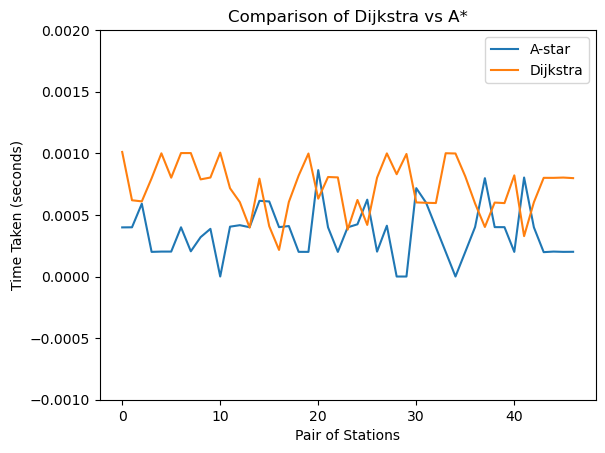

In [127]:
def compute_time_for_all_pairs(graph):
    dijkstra1 = []
    a_star = []
    stations = graph.get_nodes()
    num_stations = 100
    
    for i in range(num_stations):
        for j in range(i + 1, num_stations):
            dijkstra_times = []
            a_star_times = []
            for _ in range(5):# Avoid duplicate pairs
                source = stations[i]
                destination = stations[j]
                #getting the heuristic disctionary for euclidean distance
                h = {node : heuristic(node, destination) for node in graph.adj.keys()}
                # Compute time taken by Dijkstra's algorithm
                start_time = time.time()
                dijkstra_length, _ = dijkstra(graph, source, destination)
                end_time = time.time()
                if dijkstra_length != float('infinity'): # Path exists
                    dijkstra_times.append(end_time-start_time)

                # Compute time taken by A* algorithm

                start_time = time.time()
                _, a_star_path = A_star(graph, source, destination, h)
                end_time = time.time()
                if a_star_path is not None:
                    a_star_times.append(end_time-start_time)
            a_star.append(sum(a_star_times)/len(a_star_times)) if len(a_star_times) != 0 else 0
            dijkstra1.append(sum(dijkstra_times)/len(dijkstra_times)) if len(dijkstra_times) !=0 else 0
    return dijkstra1, a_star

# Plot a comparison graph
def plot_comparison_graph(dijkstra_times, a_star_times):
    plt.plot(a_star_times, label = "A-star")
    plt.plot(dijkstra_times, label='Dijkstra')
    plt.xlabel('Pair of Stations')
    plt.ylabel('Time Taken (seconds)')
    plt.title('Comparison of Dijkstra vs A*')
    plt.ylim(-0.0010, 0.0020)
    plt.legend()
    plt.show()

# Main code
dijkstra_times, a_star_times = compute_time_for_all_pairs(graph1)
plot_comparison_graph(dijkstra_times, a_star_times)


• What do you observe about stations which are 1) on the same lines, 2) on the adjacent lines, and
3) on the line which require several transfers?

In [144]:
def create_graph(node1, node2, weight):
    graph = DirectedWeightedGraph()
    graph.add_node(node1)
    graph.add_node(node2)
    graph.add_edge(node1, node2, weight)
    return graph

In [216]:
#graph for the stations on same line
graphs = []
sub = []
import csv
stinfo = []
# Open the CSV file in read mode
with open('london_connections.csv', newline='') as csvfile:
    # Create a CSV reader object
    reader = csv.reader(csvfile)
    
    # Iterate over each row in the CSV file
    for row in reader:
        if row[2].isdigit() and int(row[2]) == 9: #Stations on same line
            #print(row)
            stinfo.append([row[0], row[1]])
            for dis in disinfo:
                #print(dis[0], dis[1], stinfo[0], stinfo[1])
                if dis[0] == row[0]:
                    lat1_, lon1_ = float(dis[1]), float(dis[2])
                if dis[0] == row[1]:
                    lat2_, lon2_ = float(dis[1]), float(dis[2])
            sub.append([row[0], row[1], euclidean_distance(lat1_, lon1_, lat2_, lon2_)])
graph5 = DirectedWeightedGraph()
for s in sub:    
    graph5.add_node(int(s[0]))
    graph5.add_node(int(s[1]))
    
for s in sub:
    graph5.add_edge(int(s[0]), int(s[1]), s[2])
#print(graph5)


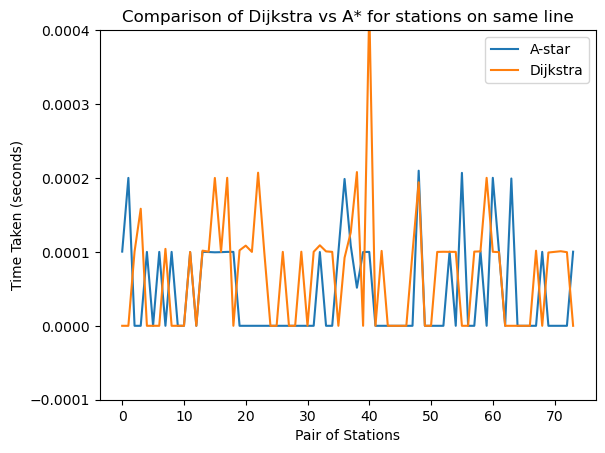

In [227]:
def compute_time_for_sameline(graph):
    dijkstra1 = []
    a_star = []
    stations = graph.get_nodes()
    num_stations = 100
    
    for i in (graph.adj.keys()):
        for j in (graph.adj.keys()):
            if i !=j:
                dijkstra_times = []
                a_star_times = []
                #print(i, j)
                for _ in range(10):
                    source = i
                    destination = j
                    #getting the heuristic disctionary for euclidean distance
                    h = {node : heuristic(node, destination) for node in graph.adj.keys()}
                    #print(graph, source, destination)
                    # Compute time taken by Dijkstra's algorithm
                    start_time = time.time()
                    dijkstra_length, _ = dijkstra(graph, source, destination)
                    end_time = time.time()
                    if dijkstra_length != float('infinity'): # Path exists
                        dijkstra_times.append(end_time-start_time)

                    # Compute time taken by A* algorithm

                    start_time = time.time()
                    _, a_star_path = A_star(graph, source, destination, h)
                    end_time = time.time()
                    if a_star_path is not None:
                        a_star_times.append(end_time-start_time)
                #print(a_star_times, dijkstra_times)
                a_star.append(sum(a_star_times)/len(a_star_times)) if len(a_star_times) != 0 else 0
                dijkstra1.append(sum(dijkstra_times)/len(dijkstra_times)) if len(dijkstra_times) !=0 else 0
    return dijkstra1, a_star

# Plot a comparison graph
def plot_comparison_graph(dijkstra_times, a_star_times):
    plt.plot(a_star_times, label = "A-star")
    plt.plot(dijkstra_times, label='Dijkstra')
    plt.xlabel('Pair of Stations')
    plt.ylabel('Time Taken (seconds)')
    plt.title('Comparison of Dijkstra vs A* for stations on same line')
    plt.ylim(-0.0001, 0.0004)
    plt.legend()
    plt.show()

# Main code
dijkstra_time, a_star_time = compute_time_for_sameline(graph5)
plot_comparison_graph(dijkstra_time, a_star_time)


In [250]:
#finding adjacent
# Sample data (replace with actual data parsing)
import csv

station_lines = []
subway_data = []

# Read the CSV file into a list of lists
with open('london_connections.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    csv_data = list(reader)
      # Skip the header row

    for row in csv_data:
        station_lines = []
        for row1 in csv_data:
            if row[0].isdigit() and row1[0].isdigit() and int(row[0]) == int(row1[0]):
                station_lines.append(row[2])
        subway_data.append((row[0], list(dict.fromkeys(station_lines))))

print(list(dict.fromkeys(subway_data)))

# Dictionary to store adjacent stations for each station
adjacent_stations = {}

# Step 1: Parse the data and identify adjacent lines
for station, lines in subway_data:
    # Step 2: Identify adjacent lines
    for line in lines:
        # Step 3: Find adjacent stations on adjacent lines
        if line not in adjacent_stations:
            adjacent_stations[line] = []
        for other_station, other_lines in subway_data:
            if station != other_station:
                for other_line in other_lines:
                    if other_line != line:
                        adjacent_stations[line].append(other_station)

# Print the result
for line, adjacent in adjacent_stations.items():
    print(f"Stations adjacent to {line}: {adjacent}")


TypeError: unhashable type: 'list'